In [1]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install transformers pandas scikit-learn matplotlib

Looking in indexes: https://download.pytorch.org/whl/cu121


In [2]:
"""
data_prep.py
Lê a planilha e cria três versões do dataset:
1) Onça - (positivo = 2, neutro = 1, negativo = 0)
2) Caseiro - (positivo = 2, neutro = 1, negativo = 0)
3) Fake News - (sim = 1, não = 0)
"""

import pandas as pd
from sklearn.model_selection import train_test_split

'''
print('teste')
try:
    df = pd.read_csv("oncas_comentarios.csv")
except Exception as e:
    print("Erro ao ler CSV:", e)
'''

# Lê o arquivo original
df = pd.read_csv("oncas_comentarios.csv", sep=";")

# Remove linhas vazias e duplicadas
df = df.dropna(subset=["comment_text"]).drop_duplicates(subset=["comment_text"])

# Função auxiliar para criar e salvar datasets
def preparar_dataset(coluna, mapa_rotulos, nome_saida):
    print(f"\nProcessando categoria: {coluna}")

    temp = df[["comment_text", coluna]].dropna()
    temp = temp.rename(columns={coluna: "label"})
    temp["label_id"] = temp["label"].map(mapa_rotulos)

    # Remove rótulos inválidos (caso haja algo diferente do mapeado)
    temp = temp.dropna(subset=["label_id"])

    # Divide o dataset
    train_df, temp_df = train_test_split(temp, test_size=0.3, random_state=42, stratify=temp["label_id"])
    val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df["label_id"])

    # Salva
    train_df.to_csv(f"train_{nome_saida}.csv", index=False)
    val_df.to_csv(f"val_{nome_saida}.csv", index=False)
    test_df.to_csv(f"test_{nome_saida}.csv", index=False)
    print(f"Arquivos salvos: train_{nome_saida}.csv, val_{nome_saida}.csv, test_{nome_saida}.csv")

# Cria datasets separados
preparar_dataset("onca", {"negativo": 0, "neutro": 1, "positivo": 2}, "onca")
preparar_dataset("caseiro", {"negativo": 0, "neutro": 1, "positivo": 2}, "caseiro")
preparar_dataset("fake news", {"não": 0, "sim": 1}, "fakenews")

print("\nTodos os datasets foram gerados com sucesso!")



Processando categoria: onca
Arquivos salvos: train_onca.csv, val_onca.csv, test_onca.csv

Processando categoria: caseiro
Arquivos salvos: train_caseiro.csv, val_caseiro.csv, test_caseiro.csv

Processando categoria: fake news
Arquivos salvos: train_fakenews.csv, val_fakenews.csv, test_fakenews.csv

Todos os datasets foram gerados com sucesso!



Treinando modelo para a categoria: ONCA


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/647 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]


Época 1/10
Loss treino: 0.5944 | Loss val: 0.5315 | Acurácia val: 0.779

Época 2/10
Loss treino: 0.3861 | Loss val: 0.4801 | Acurácia val: 0.785

Época 3/10
Loss treino: 0.1859 | Loss val: 0.6479 | Acurácia val: 0.810

Época 4/10
Loss treino: 0.0807 | Loss val: 0.6815 | Acurácia val: 0.815

Época 5/10
Loss treino: 0.0461 | Loss val: 0.7709 | Acurácia val: 0.803

Época 6/10
Loss treino: 0.0373 | Loss val: 0.7908 | Acurácia val: 0.828

Época 7/10
Loss treino: 0.0446 | Loss val: 0.8437 | Acurácia val: 0.822

Época 8/10
Loss treino: 0.0144 | Loss val: 1.0987 | Acurácia val: 0.812

Época 9/10
Loss treino: 0.0245 | Loss val: 0.9204 | Acurácia val: 0.816

Época 10/10
Loss treino: 0.0192 | Loss val: 1.4776 | Acurácia val: 0.724

 Modelo salvo: bert_onca.pt


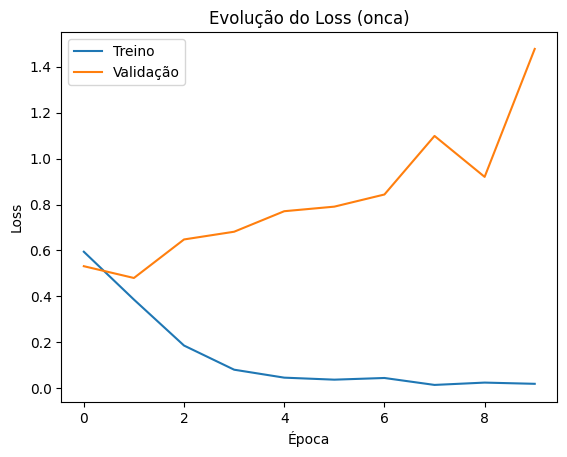

Modelo carregado com sucesso. Iniciando o treinamento...


In [11]:
"""
train_bert.py
Treina o modelo BERT para uma das categorias.
Uso:
    python train_bert.py onca
    python train_bert.py caseiro
    python train_bert.py fakenews
"""

import sys
import torch
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW # forma atual
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Verifica o argumento da categoria
sys.argv = ["train_bert.py", "onca"]
#sys.argv = ["train_bert.py", "caseiro"]
#sys.argv = ["train_bert.py", "fakenews"]

categoria = sys.argv[1]
print(f"\nTreinando modelo para a categoria: {categoria.upper()}")

# Dataset personalizado
class NewsDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=128):
        self.texts = df["comment_text"].tolist()
        self.labels = df["label_id"].tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(),
            "attention_mask": encoding["attention_mask"].squeeze(),
            "labels": torch.tensor(self.labels[idx])
        }

# Configurações
model_name = "neuralmind/bert-base-portuguese-cased"
tokenizer = BertTokenizer.from_pretrained(model_name)

# Define número de classes conforme categoria
num_labels = 3 if categoria in ["onca", "caseiro"] else 2
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Carrega dados
train_df = pd.read_csv(f"train_{categoria}.csv")
val_df = pd.read_csv(f"val_{categoria}.csv")

train_loader = DataLoader(NewsDataset(train_df, tokenizer), batch_size=8, shuffle=True)
val_loader = DataLoader(NewsDataset(val_df, tokenizer), batch_size=8)

# Otimizador
optimizer = AdamW(model.parameters(), lr=2e-5)
epochs = 10
train_losses, val_losses = [], []

# Treinamento
for epoch in range(epochs):
    print(f"\nÉpoca {epoch + 1}/{epochs}")
    model.train()
    total_loss, total_val_loss = 0, 0
    preds, labels = [], []

    for batch in train_loader:
        optimizer.zero_grad()
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    model.eval()
    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            total_val_loss += outputs.loss.item()
            preds.extend(torch.argmax(outputs.logits, dim=1).cpu().numpy())
            labels.extend(batch["labels"].cpu().numpy())

    val_acc = accuracy_score(labels, preds)
    print(f"Loss treino: {total_loss/len(train_loader):.4f} | Loss val: {total_val_loss/len(val_loader):.4f} | Acurácia val: {val_acc:.3f}")

    train_losses.append(total_loss / len(train_loader))
    val_losses.append(total_val_loss / len(val_loader))

# Salva modelo
torch.save(model.state_dict(), f"bert_{categoria}.pt")
print(f"\n Modelo salvo: bert_{categoria}.pt")

# Gráfico
plt.plot(train_losses, label="Treino")
plt.plot(val_losses, label="Validação")
plt.legend()
plt.xlabel("Época")
plt.ylabel("Loss")
plt.title(f"Evolução do Loss ({categoria})")
plt.savefig(f"loss_{categoria}.png")
plt.show()

print("Modelo carregado com sucesso.") # teste

In [16]:
import torch
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.metrics import classification_report, confusion_matrix

# Defina manualmente a categoria desejada
categoria = "onca"
#categoria = "caseiro"
#categoria = "fakenews"
print(f"\nAvaliando modelo para a categoria: {categoria.upper()}")

# Dataset personalizado
class NewsDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=128):
        self.texts = df["comment_text"].tolist()
        self.labels = df["label_id"].tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(),
            "attention_mask": encoding["attention_mask"].squeeze(),
            "labels": torch.tensor(self.labels[idx])
        }

# Configurações
model_name = "neuralmind/bert-base-portuguese-cased"
tokenizer = BertTokenizer.from_pretrained(model_name)
num_labels = 3 if categoria in ["onca", "caseiro"] else 2

model = BertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
model.load_state_dict(torch.load(f"bert_{categoria}.pt", map_location="cpu"))
model.eval()

# Dados
test_df = pd.read_csv(f"test_{categoria}.csv")
test_loader = DataLoader(NewsDataset(test_df, tokenizer), batch_size=8)

# Avaliação
preds, labels = [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        outputs = model(input_ids, attention_mask=attention_mask)
        preds.extend(torch.argmax(outputs.logits, dim=1).cpu().numpy())
        labels.extend(batch["labels"].cpu().numpy())

# Relatório
print("\nRelatório de Classificação:")
if categoria in ["onca", "caseiro"]:
    names = ["Negativo", "Neutro", "Positivo"]
else:
    names = ["Não", "Sim"]

print(classification_report(labels, preds, target_names=names))
print("Matriz de confusão:")
print(confusion_matrix(labels, preds))

# Exemplos de erros
print("\nExemplos de erros:")
for i in range(len(test_df)):
    if preds[i] != labels[i]:
        print(f"Texto: {test_df.iloc[i]['comment_text']}")
        print(f"Verdadeiro: {names[labels[i]]} | Previsto: {names[preds[i]]}\n")



Avaliando modelo para a categoria: ONCA


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Relatório de Classificação:
              precision    recall  f1-score   support

    Negativo       0.37      0.72      0.49       108
      Neutro       0.93      0.71      0.81       513
    Positivo       0.41      0.56      0.47        54

    accuracy                           0.70       675
   macro avg       0.57      0.66      0.59       675
weighted avg       0.80      0.70      0.73       675

Matriz de confusão:
[[ 78  22   8]
 [113 365  35]
 [ 18   6  30]]

Exemplos de erros:
Texto: Não faltou experiência, faltou vigilância, e ele vacilou  teria é que rapar fogo nela.
Verdadeiro: Neutro | Previsto: Negativo

Texto: Fatalidade! Chega !<br>O negativo do acontecido é q confirmou uma negativa de preservação!<br>Onça deve ser protegida sim, domesticada não!
Verdadeiro: Positivo | Previsto: Negativo

Texto: O problema tbem, é q se outra onças, provaram da carne huma , e beberam o sangue do Sr George!! Provavelmente, eles agora vão querer, caçar, mas humanos pra comer!!
Verdade